In [1]:
#Importing all neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from tensorflow.keras.layers import Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/sentiment/dta.csv',encoding='ISO-8859-1')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [5]:
data.head(10)

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467812579,Mon Apr 06 22:20:17 PDT 2009,NO_QUERY,pardonlauren,I just re-pierced my ears
8,0,1467812723,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,TLeC,@caregiving I couldn't bear to watch it. And ...
9,0,1467812771,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,robrobbierobert,"@octolinz16 It it counts, idk why I did either..."


In [6]:
data.columns = ['sentiment', 'id', 'date', 'query', 'username', 'text']
data = data[['sentiment', 'text']]


In [7]:
data.sentiment.value_counts()

0    799996
4    248576
Name: sentiment, dtype: int64

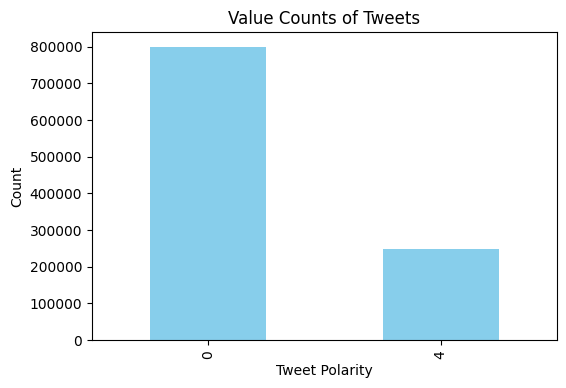

In [8]:
plt.figure(figsize=(6, 4))
data['sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Value Counts of Tweets')
plt.xlabel('Tweet Polarity')
plt.ylabel('Count')
plt.show()


In [9]:
replacement_mapping = {4: 1}
data['sentiment'] = data['sentiment'].replace(replacement_mapping)


In [10]:
#Dataset Balancing
class_0_subset = data[data['sentiment'] == 0].sample(n=248576, random_state=42)
class_1_subset=data[data['sentiment']==1]

In [11]:
data = pd.concat([class_0_subset, class_1_subset], axis=0)

In [12]:
data.sentiment.value_counts()

0    248576
1    248576
Name: sentiment, dtype: int64

EDA and text preprocessing

In [13]:
def word_count(text):
    words = text.split()  # Split the text into words
    return len(words)

# Calculate unique word counts
def unique_word_count(text):
    words = text.split()  # Split the text into words
    unique_words = set(words)  # Use a set to get unique words
    return len(unique_words)

# Apply the word_count and unique_word_count functions
data['word_count'] = data['text'].apply(word_count)
data['unique_word_count'] = data['text'].apply(unique_word_count)

# Calculate average, minimum, and maximum words per review, and unique word counts
average_words_per_review = data['word_count'].mean()
min_words_per_review = data['word_count'].min()
max_words_per_review = data['word_count'].max()

average_unique_words_per_review = data['unique_word_count'].mean()
min_unique_words_per_review = data['unique_word_count'].min()
max_unique_words_per_review = data['unique_word_count'].max()

print("Average Words per Tweet:", average_words_per_review)
print("Minimum Words per Tweet:", min_words_per_review)
print("Maximum Words per Tweet:", max_words_per_review)

print("Average Unique Words per Tweet:", average_unique_words_per_review)
print("Minimum Unique Words per Tweet:", min_unique_words_per_review)
print("Maximum Unique Words per Tweet:", max_unique_words_per_review)



Average Words per Tweet: 13.20797261199794
Minimum Words per Tweet: 1
Maximum Words per Tweet: 41
Average Unique Words per Tweet: 12.635280558058703
Minimum Unique Words per Tweet: 1
Maximum Unique Words per Tweet: 37


In [14]:
unique_words = set()  # Initialize an empty set to store unique words

for text in data['text']:
    words = text.split()  # Split the text into words
    unique_words.update(words)  # Add words to the set

num_unique_words = len(unique_words)

print("Number of Unique Words:", num_unique_words)


Number of Unique Words: 571086


In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
print(stop_words)


{'were', 'while', "needn't", 'are', 'so', 'd', "should've", 'a', "you're", 'we', 'if', "you'll", "weren't", 've', "she's", 'aren', 'been', 'of', 're', 'be', 'will', 'in', 'against', 'off', 'few', 'ours', "mightn't", 'some', 'll', "aren't", 'theirs', 'mustn', "it's", 'too', 'before', 'your', 'myself', 'ourselves', "shan't", 'my', 'nor', 'do', 'for', "wouldn't", 'by', 'who', 'doing', 'themselves', 'other', 'because', 'such', 'they', 'with', 'himself', 'only', "shouldn't", 'mightn', "that'll", "wasn't", 'me', 'her', 'won', 'yourselves', 'than', 'from', "won't", 'most', 'its', 'what', 'can', "you've", 'herself', 'very', 'now', 'you', 'being', 'wasn', 'has', 'just', 'any', 'same', 'their', 'under', 'once', 'where', 'each', 'further', 'here', 'had', "doesn't", 'into', 'wouldn', 'or', 'no', 'hadn', 'after', 'have', 'then', 'both', 'was', 'him', 'his', "you'd", 'below', 'i', 'that', 'at', 'why', 'whom', 'about', 'this', 'there', 'over', 'not', 'our', 'it', 'o', 'those', 'to', 'more', 'own', 'h

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
stopwords={"you'll", 'until', 'y', 'all', 'after', 'he', 'will', 'those', "you're", 'into',
           'so', 'for', "hadn't", 't', 'how', 're',
           'has', 'me', 'had', "you've", 'our', 'because', 'itself', 'other', 'being',
           'should', 'she', "you'd", 'll', 'won', 'to', 'some', 'where', 'was', 'own', 'only', 'as', 'before',
           'any', 'such', 'and', "she's", 'they', 'ain', 'between', 'at', 'the', 'shouldn', 'here',
           'myself', 'do', 'haven', 'his', 'which', 'am', 'up', 'that', 'doesn', 'my', 'down', 'their', 'wasn', 'whom',
           'more', 'with', 'most', 'don', 'now', 'each', 'we', 'shan', 'its', 'again', 'd', 'once', 'yourself',
           'if', "doesn't", 'doing', 'hadn', 'what', 'who', 'you', 'out', 'your', 'too', 'yourselves', 'in',
           'both', 'above', 'over', 'same', 'is', 'nor', 'further', 'an', 'hasn', 'o', "shouldn't",
           'under', 'below', "should've", 'them', 'herself', 'himself', 'm', 'through', 'a', 'mightn', 'this',
          'than', "weren't", 'ourselves', "it's", 'ma', 'off', 'yours', 'ours', 'there', 'weren', 'him', 'did',
           'on', 'theirs', 'were', 'few', 'by', 'just', 've', 'then', 'are', 'from', "didn't", "that'll", 'about', 's', 'been',
           'when', 'during', 'why', 'hers', 'these', 'of', 'themselves', 'can', 'while', 'very',
           'aren', 'her', 'have', 'i', 'be', 'it', 'having', 'but', 'or'}

In [17]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Contractions mapping
contractions_mapping = {
    "can't": "can not",
    "won't": "will not",
    "don't": "do not",
    "didn't": "did not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "doesn't": "does not",
    "haven't": "have not",
    "hasn't": "has not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "who's": "who is",
    "what's": "what is",
    "where's": "where is",
    "when's": "when is",
    "why's": "why is"
    # Add more contractions as needed
}



In [18]:
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')


# Function to handle contractions and clean text
def clean_text(text):
    # Replace specific contractions with expanded forms
    for contraction, expansion in contractions_mapping.items():
        text = text.replace(contraction, expansion)

    # Replace non-letters with spaces, remove extra spaces, and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', text)  # Replace non-letters with spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with a single space
    cleaned_text = cleaned_text.strip()  # Remove leading and trailing spaces
    cleaned_text = cleaned_text.lower()  # Convert to lowercase
    tokens = word_tokenize(cleaned_text)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    cleanedtext = ' '.join(lemmatized_tokens)

    return cleanedtext
# Apply the function to the 'text_column' and create a new column 'cleaned_text'
data['cleaned_text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
data[['cleaned_text','sentiment']][:20]

,cleaned_text,sentiment
212188,amruth early bird didnt reply facebook wall po...,0
674330,sooo hot tonight wish pool outside skinny dipp...,0
752234,darkandrez washing clothes,0
415739,asexiness suck,0
138859,watch yet finale ai waiting replay always miss...,0
296448,skip english class homework,0
490672,syahirahanwar hmm medium audience start tooo b...,0
257163,believe still license one ever time take drivi...,0
569661,attach picture tree fell truck,0
517317,beakee co munch gobble collapsing bed book sou...,0


Data Preperation Model Traning and Evaluation

In [20]:
sentences=data['cleaned_text']
reviews=list(data['sentiment'])

In [21]:
sentences

212188     amruth early bird didnt reply facebook wall po...
674330     sooo hot tonight wish pool outside skinny dipp...
752234                            darkandrez washing clothes
415739                                        asexiness suck
138859     watch yet finale ai waiting replay always miss...
                                 ...                        
1048567                            grandma making dinenr mum
1048568        mid morning snack time bowl cheese noodle yum
1048569    shadela say like terminiator movie come like word
1048570                    destinyhope im great thaanks wbuu
1048571                           cant wait til date weekend
Name: cleaned_text, Length: 497152, dtype: object

In [22]:
#Train Validation Split
X_train, X_val, y_train, y_val = train_test_split(sentences, reviews,
                                                    test_size=0.3,
                                                    random_state=1)


In [23]:
max_seq_length=32
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
max_words = 70000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
import numpy as np
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_seq_length, padding='post')
X_train_padded = np.array(X_train_padded)
X_val_padded = np.array(X_val_padded)
y_val=np.array(y_val)
y_train=np.array(y_train)



In [24]:
import pickle
# Save tokenizer
with open('/content/drive/MyDrive/sentiment/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [60]:
test=pd.read_csv('/content/drive/MyDrive/sentiment/testdata.a.2009.06.14.csv')
test


,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
...,...,...,...,...,...,...
510,4,14083,Mon May 11 03:33:38 UTC 2009,nashta,theviewfans,House Correspondents dinner was last night who...
511,4,14084,Mon May 11 05:22:12 UTC 2009,nashta,peterlikewhat,lebron and zydrunas are such an awesome duo
512,4,14085,Mon May 11 05:22:37 UTC 2009,nashta,emceet,@wordwhizkid Lebron is a beast... nobody in th...
513,4,14086,Mon May 11 05:21:45 UTC 2009,nashta,Native_011,@Pmillzz lebron IS THE BOSS


In [61]:
#Test Set preperation
test=test.iloc[:, [0, 5]]
test.columns=['sentiment','text']
test=test[test.sentiment!=2]
replacement_mapping = {4: 1}
test['sentiment'] = test['sentiment'].replace(replacement_mapping)

test['cleaned_text'] = test['text'].apply(clean_text)
X_test=test['cleaned_text']
y_test=list(test['sentiment'])
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=32, padding='post')
X_test_padded = np.array(X_test_padded)
y_test=np.array(y_test)






Simple LSTM Model


In [ ]:
# Simple LSTM model
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/sentiment/best_model.h5', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=128,
                    validation_data=(X_val_padded, y_val),
                    callbacks=[early_stopping, model_checkpoint])


# Evaluate the best model on test data
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/best_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)




Epoch 1/5
  80/2719 [..............................] - ETA: 12:16 - loss: 0.6935 - accuracy: 0.5082

KeyboardInterrupt: ignored

In [52]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/best_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



12/12 [==============================] - 0s 12ms/step - loss: 0.4963 - accuracy: 0.7627
Test Loss: 0.49630239605903625
Test Accuracy: 0.762666642665863


In [53]:
y_pred=best_model.predict(X_test_padded)
y_pred = (y_pred >0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
metrics_dict={}
metrics_dict['simple_lstm'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}



12/12 [==============================] - 0s 11ms/step


Multiple lstm model


In [ ]:
model_multiple_lstm = Sequential()


# Add Embedding layer
model_multiple_lstm.add(Embedding(input_dim=max_words, output_dim=256, input_length=max_seq_length))

# Add multiple LSTM layers
model_multiple_lstm.add(LSTM(128, return_sequences=True))  # First LSTM layer
model_multiple_lstm.add(LSTM(64, return_sequences=True))   # Second LSTM layer
model_multiple_lstm.add(LSTM(32))                          # Third LSTM layer

model_multiple_lstm.add(Dense(1, activation='sigmoid'))

model_multiple_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/sentiment/best_mlstm_model.h5', save_best_only=True, save_weights_only=False)

# Train the model
history = model_multiple_lstm.fit(X_train_padded, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val_padded, y_val),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
2719/2719 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.7635

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2719/2719 [==============================] - 1950s 714ms/step - loss: 0.4870 - accuracy: 0.7635 - val_loss: 0.4594 - val_accuracy: 0.7819
Epoch 2/10
2719/2719 [==============================] - 1887s 694ms/step - loss: 0.4047 - accuracy: 0.8145 - val_loss: 0.4616 - val_accuracy: 0.7822
Epoch 3/10
2719/2719 [==============================] - 1840s 677ms/step - loss: 0.3340 - accuracy: 0.8513 - val_loss: 0.4989 - val_accuracy: 0.7752
Epoch 4/10
2719/2719 [==============================] - 1911s 703ms/step - loss: 0.2708 - accuracy: 0.8812 - val_loss: 0.5979 - val_accuracy: 0.7671


In [54]:
# Evaluate the best model on test data
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/best_mlstm_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)




12/12 [==============================] - 1s 7ms/step - loss: 0.4681 - accuracy: 0.7707
Test Loss: 0.46811413764953613
Test Accuracy: 0.7706666588783264


In [55]:
y_pred=best_model.predict(X_test_padded)
y_pred = (y_pred >0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
metrics_dict['multiple_lstm'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}



12/12 [==============================] - 1s 6ms/step


 Simple  Bidirectional LSTM model

In [ ]:



embedding_dim = 256

model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
model2.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/sentiment/best_bidirectional_model.h5', save_best_only=True, save_weights_only=False)

# Train the model
history = model2.fit(X_train_padded, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val_padded, y_val),
                    callbacks=[early_stopping, model_checkpoint])





Epoch 1/10


KeyboardInterrupt: ignored

In [56]:
# Evaluate the best model on test data
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/best_bidirectional_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


12/12 [==============================] - 31s 29ms/step - loss: 0.4560 - accuracy: 0.7840
Test Loss: 0.45604467391967773
Test Accuracy: 0.7839999794960022


In [57]:
y_pred=best_model.predict(X_test_padded)
y_pred = (y_pred >0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
metrics_dict['simple_bi_lstm'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}



12/12 [==============================] - 1s 30ms/step


Bidirectional+ Simple Lstm Model

In [ ]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_words, output_dim=512, input_length=max_seq_length))
model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(LSTM(64, return_sequences=True))
model3.add(LSTM(32))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/sentiment/best_bidirectionalwith_mlstm_model.h5', save_best_only=True, save_weights_only=False)

# Train the model
history = model3.fit(X_train_padded, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val_padded, y_val),
                    callbacks=[early_stopping, model_checkpoint])





Epoch 1/10
2719/2719 [==============================] - 99s 34ms/step - loss: 0.4846 - accuracy: 0.7643 - val_loss: 0.4580 - val_accuracy: 0.7831
Epoch 2/10
2719/2719 [==============================] - 68s 25ms/step - loss: 0.3964 - accuracy: 0.8188 - val_loss: 0.4636 - val_accuracy: 0.7818
Epoch 3/10
2719/2719 [==============================] - 66s 24ms/step - loss: 0.3203 - accuracy: 0.8580 - val_loss: 0.5125 - val_accuracy: 0.7762
Epoch 4/10
12/12 [==============================] - 2s 8ms/step - loss: 0.4727 - accuracy: 0.7947
Test Loss: 0.47272789478302
Test Accuracy: 0.7946666479110718


In [58]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/best_bidirectionalwith_mlstm_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_pred=best_model.predict(X_test_padded)
y_pred = (y_pred >0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
metrics_dict['bi_and_lstm'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}





12/12 [==============================] - 2s 10ms/step - loss: 0.4749 - accuracy: 0.7787
Test Loss: 0.4748861789703369
Test Accuracy: 0.7786666750907898
12/12 [==============================] - 2s 8ms/step


Multiple Bidirectional LSTM



In [ ]:
model4 = Sequential()
model4.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
model4.add(Bidirectional(LSTM(128, return_sequences=True)))
model4.add(Bidirectional(LSTM(64, return_sequences=True)))
model4.add(Bidirectional(LSTM(32)))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/sentiment/best_bidirectionalwithbilstm_model.h5', save_best_only=True, save_weights_only=False)

# Train the model
history = model4.fit(X_train_padded, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val_padded, y_val),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
2719/2719 [==============================] - 87s 29ms/step - loss: 0.4771 - accuracy: 0.7679 - val_loss: 0.4542 - val_accuracy: 0.7835
Epoch 2/10
2719/2719 [==============================] - 62s 23ms/step - loss: 0.3947 - accuracy: 0.8192 - val_loss: 0.4604 - val_accuracy: 0.7828
Epoch 3/10
2719/2719 [==============================] - 58s 21ms/step - loss: 0.3299 - accuracy: 0.8527 - val_loss: 0.5028 - val_accuracy: 0.7742
Epoch 4/10
12/12 [==============================] - 3s 10ms/step - loss: 0.4654 - accuracy: 0.7893
Test Loss: 0.46543169021606445
Test Accuracy: 0.7893333435058594


In [59]:
# Evaluate the best model on test data
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/best_bidirectionalwithbilstm_model.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_pred=best_model.predict(X_test_padded)
y_pred = (y_pred >0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
metrics_dict['multiple_bi_lstm'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}



12/12 [==============================] - 3s 11ms/step - loss: 0.4639 - accuracy: 0.7893
Test Loss: 0.46394068002700806
Test Accuracy: 0.7893333435058594
12/12 [==============================] - 4s 10ms/step


Simple Attention Based Encoder Model

In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models

def transformer_model(max_seq_length=32, embed_dim=32, num_heads=2, ff_dim=32):
    inputs = layers.Input(shape=(max_seq_length,))
    x = inputs

    # Embedding layer with custom embedding dimension
    embedded_x = layers.Embedding(input_dim=max_words, output_dim=embed_dim, input_length=max_seq_length)(x)

    # Positional Encoding
    positions = tf.range(start=0, limit=max_seq_length, delta=1)
    positions = layers.Embedding(input_dim=max_seq_length, output_dim=embed_dim)(positions)
    positions = tf.reduce_sum(positions, axis=1, keepdims=True)  # Sum along the sequence axis with keepdims=True
    x = embedded_x + positions

    # Transformer Blocks
    for _ in range(1):  # You can adjust the number of blocks based on your requirements
        # Multi-Head Self-Attention
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Dropout(0.1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + embedded_x)  # Corrected the addition here

        # Feed-forward layer
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(0.1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + embedded_x)  # Corrected the addition here

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [67]:

# Create the transformer model
model = transformer_model()

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display the model summary

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 32)               2240000   ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 32, 32)               0         ['embedding[0][0]']           
 Lambda)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 32, 32)               8416      ['tf.__operators__.add[0][

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/sentiment/ATT.h5', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=128,
                    validation_data=(X_val_padded, y_val),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
2719/2719 [==============================] - 54s 17ms/step - loss: 0.5038 - accuracy: 0.7515 - val_loss: 0.4672 - val_accuracy: 0.7757
Epoch 2/10
2719/2719 [==============================] - 25s 9ms/step - loss: 0.4344 - accuracy: 0.7969 - val_loss: 0.4673 - val_accuracy: 0.7783
Epoch 3/10
2719/2719 [==============================] - 30s 11ms/step - loss: 0.4010 - accuracy: 0.8138 - val_loss: 0.4863 - val_accuracy: 0.7760
Epoch 4/10
2719/2719 [==============================] - 28s 10ms/step - loss: 0.3706 - accuracy: 0.8276 - val_loss: 0.5032 - val_accuracy: 0.7727


In [62]:
# Evaluate the best model on test data
best_model = tf.keras.models.load_model('/content/drive/MyDrive/sentiment/ATT.h5')

test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_pred=best_model.predict(X_test_padded)
y_pred = (y_pred >0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
metrics_dict['Attention'] = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}




12/12 [==============================] - 0s 4ms/step - loss: 0.4726 - accuracy: 0.7787
Test Loss: 0.47262826561927795
Test Accuracy: 0.7786666750907898
12/12 [==============================] - 0s 3ms/step


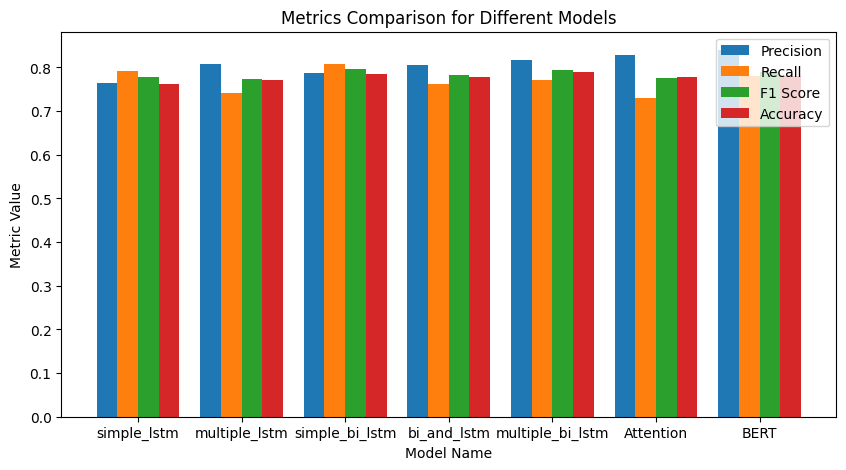

In [73]:
# Extract model names and metrics for plotting
model_names = list(metrics_dict.keys())
metrics_names = list(metrics_dict[model_names[0]].keys())  # Assuming all models have the same metrics

# Plot all metrics in a single grouped bar chart
bar_width = 0.2
index = np.arange(len(model_names))
plt.figure(figsize=(10, 5))
for i, metric_name in enumerate(metrics_names):
    metric_values = [metrics_dict[model_name][metric_name] for model_name in model_names]
    plt.bar(index + i * bar_width, metric_values, bar_width, label=metric_name)

plt.xlabel('Model Name')
plt.ylabel('Metric Value')
plt.title('Metrics Comparison for Different Models')
plt.xticks(index + bar_width * (len(metrics_names) - 1) / 2, model_names)
plt.legend()
plt.show()


Manual predictions

In [64]:
input_text = "hurray we are the winners !"

# Preprocess the input text
cleaned_text = clean_text(input_text)  # Use your preprocessing function
input_sequence = tokenizer.texts_to_sequences([cleaned_text])
input_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_seq_length)

# Make predictions
predicted_probabilities = best_model.predict(input_sequence_padded)
predicted_sentiment = "Positive" if predicted_probabilities >0.5 else "Negative"

print("Input Text:", input_text)
print("Predicted Sentiment:", predicted_sentiment)
if (predicted_probabilities>0.5):
  print("Predicted Probability:", predicted_probabilities[0][0])
else:
   print("Predicted Probability:", 1-predicted_probabilities[0][0])

1/1 [==============================] - 0s 129ms/step
Input Text: hurray we are the winners !
Predicted Sentiment: Positive
Predicted Probability: 0.84667945


In [65]:
input_text = "i am extremly dissapointed by my marks"

# Preprocess the input text
cleaned_text = clean_text(input_text)  # Use your preprocessing function
input_sequence = tokenizer.texts_to_sequences([cleaned_text])
input_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_seq_length)

# Make predictions
predicted_probabilities = best_model.predict(input_sequence_padded)
predicted_sentiment = "Positive" if predicted_probabilities >0.5 else "Negative"

print("Input Text:", input_text)
print("Predicted Sentiment:", predicted_sentiment)
if (predicted_probabilities>0.5):
  print("Predicted Probability:", predicted_probabilities[0][0])
else:
   print("Predicted Probability:", 1-predicted_probabilities[0][0])

1/1 [==============================] - 0s 18ms/step
Input Text: i am extremly dissapointed by my marks
Predicted Sentiment: Negative
Predicted Probability: 0.9485805854201317
